<a href="https://colab.research.google.com/github/geporys/ts-project-assignment-hse-2023/blob/main/ExportForecastLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys 
sys.path.append("/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/functions")

In [2]:
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf
from functions.data import get_NIC_from_yFinance, get_nickel_data_from_businessinsider, get_rates, union_data_in_one_df, get_AUDIDR_from_yFinance, get_endog_and_exog
from functions.chart import plot_nick_rate_nic
from functions.model import first_model


In [3]:
currency_df = get_AUDIDR_from_yFinance()

<AxesSubplot: xlabel='Date'>

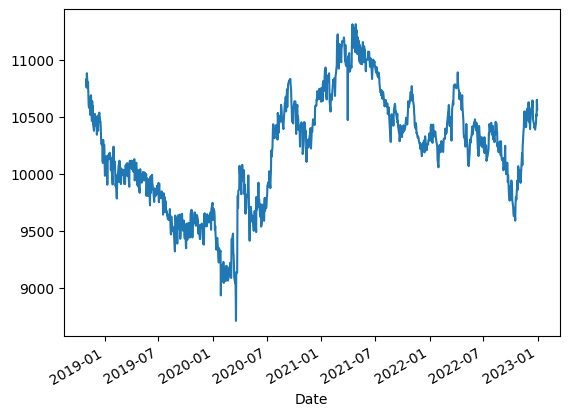

In [4]:
currency_df['Close'].plot()

In [5]:
currency_df.index.normalize()

DatetimeIndex(['2018-10-31 00:00:00+11:00', '2018-11-01 00:00:00+11:00',
               '2018-11-02 00:00:00+11:00', '2018-11-05 00:00:00+11:00',
               '2018-11-06 00:00:00+11:00', '2018-11-07 00:00:00+11:00',
               '2018-11-08 00:00:00+11:00', '2018-11-09 00:00:00+11:00',
               '2018-11-12 00:00:00+11:00', '2018-11-13 00:00:00+11:00',
               ...
               '2022-12-19 00:00:00+11:00', '2022-12-20 00:00:00+11:00',
               '2022-12-21 00:00:00+11:00', '2022-12-22 00:00:00+11:00',
               '2022-12-23 00:00:00+11:00', '2022-12-26 00:00:00+11:00',
               '2022-12-27 00:00:00+11:00', '2022-12-28 00:00:00+11:00',
               '2022-12-29 00:00:00+11:00', '2022-12-30 00:00:00+11:00'],
              dtype='datetime64[ns, Australia/Sydney]', name='Date', length=1088, freq=None)

In [6]:
nic_df = get_NIC_from_yFinance()

In [7]:
nic_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-10-31 00:00:00+11:00,0.243202,0.252209,0.234194,0.247705,640285,0.0,0.0
2018-11-01 00:00:00+11:00,0.247705,0.270224,0.234194,0.243202,1726009,0.0,0.0
2018-11-02 00:00:00+11:00,0.252209,0.252209,0.245003,0.247705,181966,0.0,0.0
2018-11-05 00:00:00+11:00,0.252209,0.256713,0.247705,0.247705,1444336,0.0,0.0
2018-11-06 00:00:00+11:00,0.243202,0.261217,0.238698,0.261217,546481,0.0,0.0
...,...,...,...,...,...,...,...
2022-09-26 00:00:00+10:00,0.779563,0.789369,0.764854,0.779563,15205621,0.0,0.0
2022-09-27 00:00:00+10:00,0.779563,0.794272,0.769757,0.784466,12283210,0.0,0.0
2022-09-28 00:00:00+10:00,0.789369,0.789369,0.745243,0.755049,15720741,0.0,0.0


In [8]:
(nic_df, nickel_df) = get_nickel_data_from_businessinsider(nic_df)

In [9]:
nickel_df[nickel_df['Close'].isnull()]

,Close,Open,High,Low,Volume,Estimate,Date
Date,,,,,,,


In [10]:
rates = get_rates(nic_df)

In [11]:
ind_exp = pd.read_excel("forecasting_ts_project_raw_data/TABEL5_14_volume by sector.xls", sheet_name='5.14', header=4)

In [12]:
ind_exp = ind_exp.transpose().reset_index()

In [13]:
ind_exp_cols = ['Year', 'Month'] + list(ind_exp.iloc[176][2:69]) + ['drop1', 'drop2']
ind_exp.columns = ind_exp_cols

In [14]:
ind_exp = ind_exp[3:174].drop(columns=['drop1', 'drop2'])

In [15]:
bo = ~ind_exp['Year'].str.contains('Unnamed').fillna(False)
ind_exp['Year'] = ind_exp['Year'].where(bo).fillna(method='ffill')

In [16]:
ind_exp = ind_exp[~ind_exp['Month'].isna()]

In [17]:
ind_exp['Month'] = ind_exp['Month'].str.replace('*', '')

/var/folders/41/gxq0b1712fbb5k5ndrr4d4cw0000gn/T/ipykernel_71310/3288374492.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  ind_exp['Month'] = ind_exp['Month'].str.replace('*', '')


In [18]:
ind_exp['Day'] = 1
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
ind_exp.replace({'Month': months}, inplace=True)

In [19]:
dt = pd.to_datetime(ind_exp[['Year', 'Month', 'Day']], format="%Y%m%d")
ind_exp['Date'] = [pd.Timestamp(t, tz='Australia/Sydney') for t in dt]

In [20]:
ind_exp.set_index('Date', inplace=True)
ind_exp = ind_exp.asfreq(freq='m', method='ffill').fillna(method='ffill')

In [21]:
ind_exp = ind_exp[['Base metal products', 'Nickel ore']]
ind_exp = ind_exp.asfreq(freq='B').fillna(method='ffill')

# Slice period 
ind_exp = ind_exp['2018-10-31':'2022-09-30']

<AxesSubplot: xlabel='Date'>

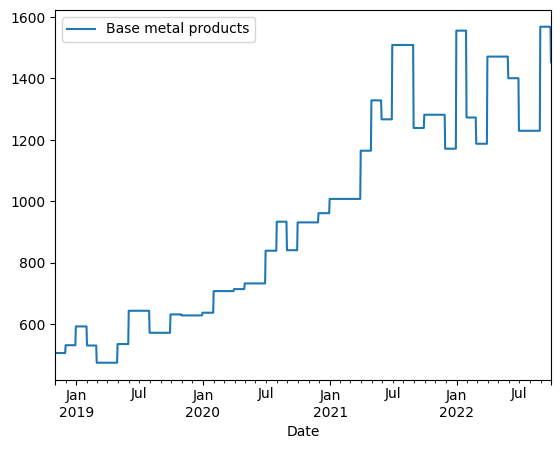

In [22]:
ind_exp.plot()

In [23]:
ind_exp[ind_exp['Base metal products'].isnull()]

,Base metal products,Nickel ore
Date,,


In [24]:
ind_exp

,Base metal products,Nickel ore
Date,,
2018-10-31 00:00:00+11:00,506.75,1968.14
2018-11-01 00:00:00+11:00,506.75,1968.14
2018-11-02 00:00:00+11:00,506.75,1968.14
2018-11-05 00:00:00+11:00,506.75,1968.14
2018-11-06 00:00:00+11:00,506.75,1968.14
...,...,...
2022-09-26 00:00:00+10:00,1568.34,-
2022-09-27 00:00:00+10:00,1568.34,-
2022-09-28 00:00:00+10:00,1568.34,-


In [25]:
mining = pd.DataFrame(data=[
    {'date': '2018-07-01', 'value': 36933},
    {'date': '2018-08-01', 'value': 40904},
    {'date': '2018-09-01', 'value': 48155},
    {'date': '2018-10-01', 'value': 40579},
    {'date': '2018-11-01', 'value': 43322},
    {'date': '2018-12-01', 'value': 39275},
    {'date': '2019-01-01', 'value': 39848},
    {'date': '2019-02-01', 'value': 42772},
    {'date': '2019-03-01', 'value': 44576},
    {'date': '2019-04-01', 'value': 20509},
    {'date': '2019-05-01', 'value': 33281},
    {'date': '2019-06-01', 'value': 24461},
    {'date': '2019-07-01', 'value': 57000},
    {'date': '2019-08-01', 'value': 64000},
    {'date': '2019-09-01', 'value': 77950},
    {'date': '2019-10-01', 'value': 69734},
    {'date': '2019-11-01', 'value': 56086},
    {'date': '2019-12-01', 'value': 68339},
    {'date': '2020-01-01', 'value': 50600},
    {'date': '2020-02-01', 'value': 49666},
    {'date': '2020-03-01', 'value': 49643},
    {'date': '2020-04-01', 'value': 12500},
    {'date': '2020-05-01', 'value': 25400},
    {'date': '2020-06-01', 'value': 24600},
    {'date': '2020-07-01', 'value': 9500},
    {'date': '2020-08-01', 'value': 45900},
    {'date': '2020-09-01', 'value': 102800},
    {'date': '2020-10-01', 'value': 174193},
    {'date': '2020-11-01', 'value': 173930},
    {'date': '2020-12-01', 'value': 151764},
    {'date': '2021-01-01', 'value': 156039},
    {'date': '2021-02-01', 'value': 117728},
    {'date': '2021-03-01', 'value': 182720},
    {'date': '2021-04-01', 'value': 196617},
    {'date': '2021-05-01', 'value': 142056},
    {'date': '2021-06-01', 'value': 236118},
    {'date': '2021-07-01', 'value': 166506},
    {'date': '2021-08-01', 'value': 193068},
    {'date': '2021-09-01', 'value': 219582},
    {'date': '2021-10-01', 'value': 283494},
    {'date': '2021-11-01', 'value': 213090},
    {'date': '2021-12-01', 'value': 313740},
    {'date': '2022-01-01', 'value': 792630/3},
    {'date': '2022-02-01', 'value': 792630/3},
    {'date': '2022-03-01', 'value': 792630/3},
    {'date': '2022-04-01', 'value': 599590/3},
    {'date': '2022-05-01', 'value': 599590/3},
    {'date': '2022-06-01', 'value': 599590/3},
    {'date': '2022-07-01', 'value': 339672},
    {'date': '2022-08-01', 'value': 205722},
    {'date': '2022-09-30', 'value': 301866},
])


mining['date'] = [pd.Timestamp(t, tz='Australia/Sydney') for t in mining['date']]


mining = mining.set_index('date')
mining = mining.asfreq(freq='B').fillna(method='ffill')
mining = mining[mining.index >= nic_df.index[0]]

In [26]:
mining[mining['value'].isnull()]

,value
date,


<AxesSubplot: xlabel='date'>

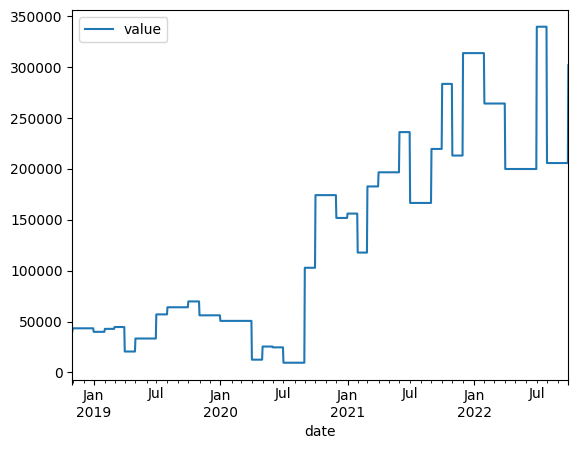

In [27]:
mining.plot()

In [28]:
production = pd.DataFrame(data=[
     {'date': '2018-01-01', 'value': 0},
     {'date': '2018-02-01', 'value': 0},
     {'date': '2018-03-01', 'value': 0},
     {'date': '2018-04-01', 'value': 0},
     {'date': '2018-05-01', 'value': 0},
     {'date': '2018-06-01', 'value': 0},
     {'date': '2018-07-01', 'value': 0},
     {'date': '2018-08-01', 'value': 0},
     {'date': '2018-09-01', 'value': 0},
     {'date': '2018-10-01', 'value': 0},
     {'date': '2018-11-01', 'value': 0},
     {'date': '2018-12-01', 'value': 0},
     {'date': '2019-01-01', 'value': 67.5},
     {'date': '2019-02-01', 'value': 1802},
     {'date': '2019-03-01', 'value': 6502},
     {'date': '2019-04-01', 'value': 8684.8},
     {'date': '2019-05-01', 'value': 11320.5+123.1},
     {'date': '2019-06-01', 'value': 1251.1 + 2354.0},
     {'date': '2019-07-01', 'value': 12700 + 8053},
     {'date': '2019-08-01', 'value': 13405 + 12389},
     {'date': '2019-09-01', 'value': 13451 + 12375},
     {'date': '2019-10-01', 'value': 14937.5 + 13595.3},
     {'date': '2019-11-01', 'value': 12978.0 + 13433.4},
     {'date': '2019-12-01', 'value': 12995.2 + 12076.0},
     {'date': '2020-01-01', 'value': 26858},
     {'date': '2020-02-01', 'value': 25449},
     {'date': '2020-03-01', 'value': 27090},
     {'date': '2020-04-01', 'value': 23179},
     {'date': '2020-05-01', 'value': 24777},
     {'date': '2020-06-01', 'value': 21645},
     {'date': '2020-07-01', 'value': 20768},
     {'date': '2020-08-01', 'value': 23326},
     {'date': '2020-09-01', 'value': 25737},
     {'date': '2020-10-01', 'value': 26068.3},
     {'date': '2020-11-01', 'value': 24542.3},
     {'date': '2020-12-01', 'value': 26456.1},
     {'date': '2021-01-01', 'value': 22170.9},
     {'date': '2021-02-01', 'value': 24497.3},
     {'date': '2021-03-01', 'value': 25271.1},
     {'date': '2021-04-01', 'value': 23991.5},
     {'date': '2021-05-01', 'value': 26383.7},
     {'date': '2021-06-01', 'value': 24111.3},
     {'date': '2021-07-01', 'value': 25146.1},
     {'date': '2021-08-01', 'value': 26305.5},
     {'date': '2021-09-01', 'value': 21702.8},
     {'date': '2021-10-01', 'value': 24589},
     {'date': '2021-11-01', 'value': 26028},
     {'date': '2021-12-01', 'value': 28155}, 
     {'date': '2022-01-01', 'value': 12222 + 12812},
     {'date': '2022-02-01', 'value': 11853 + 11863 + 1939},
     {'date': '2022-03-01', 'value': 12783 + 12556 + 5571 },
     {'date': '2022-04-01', 'value': 114106 / 3},
     {'date': '2022-05-01', 'value': 114106 / 3},
     {'date': '2022-06-01', 'value': 114106 / 3},
     {'date': '2022-07-01', 'value': 145180 / 3},
     {'date': '2022-08-01', 'value': 145180 / 3},
     {'date': '2022-09-30', 'value': 145180 / 3},
])

production['date'] = [pd.Timestamp(t, tz='Australia/Sydney') for t in production['date']]


production = production.set_index('date')
production = production.asfreq(freq='B').fillna(method='ffill')
production = production[production.index >= nic_df.index[0]]

In [29]:
production[production['value'].isnull()]

,value
date,


<AxesSubplot: xlabel='date'>

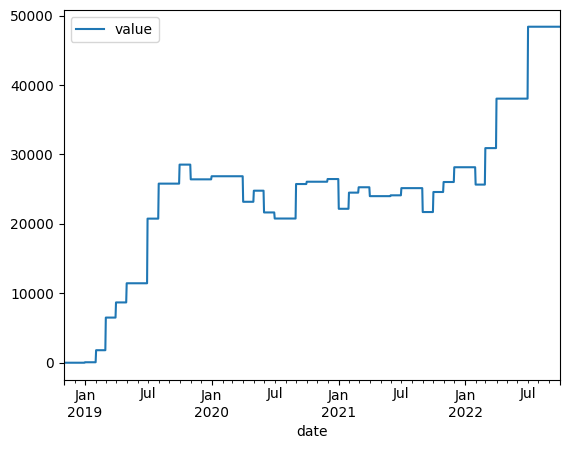

In [30]:
production.plot()

In [31]:
rates

,rate
date,
2018-10-31 00:00:00+11:00,1.50
2018-11-01 00:00:00+11:00,1.50
2018-11-02 00:00:00+11:00,1.50
2018-11-05 00:00:00+11:00,1.50
2018-11-06 00:00:00+11:00,1.50
...,...
2022-09-26 00:00:00+10:00,2.35
2022-09-27 00:00:00+10:00,2.35
2022-09-28 00:00:00+10:00,2.35


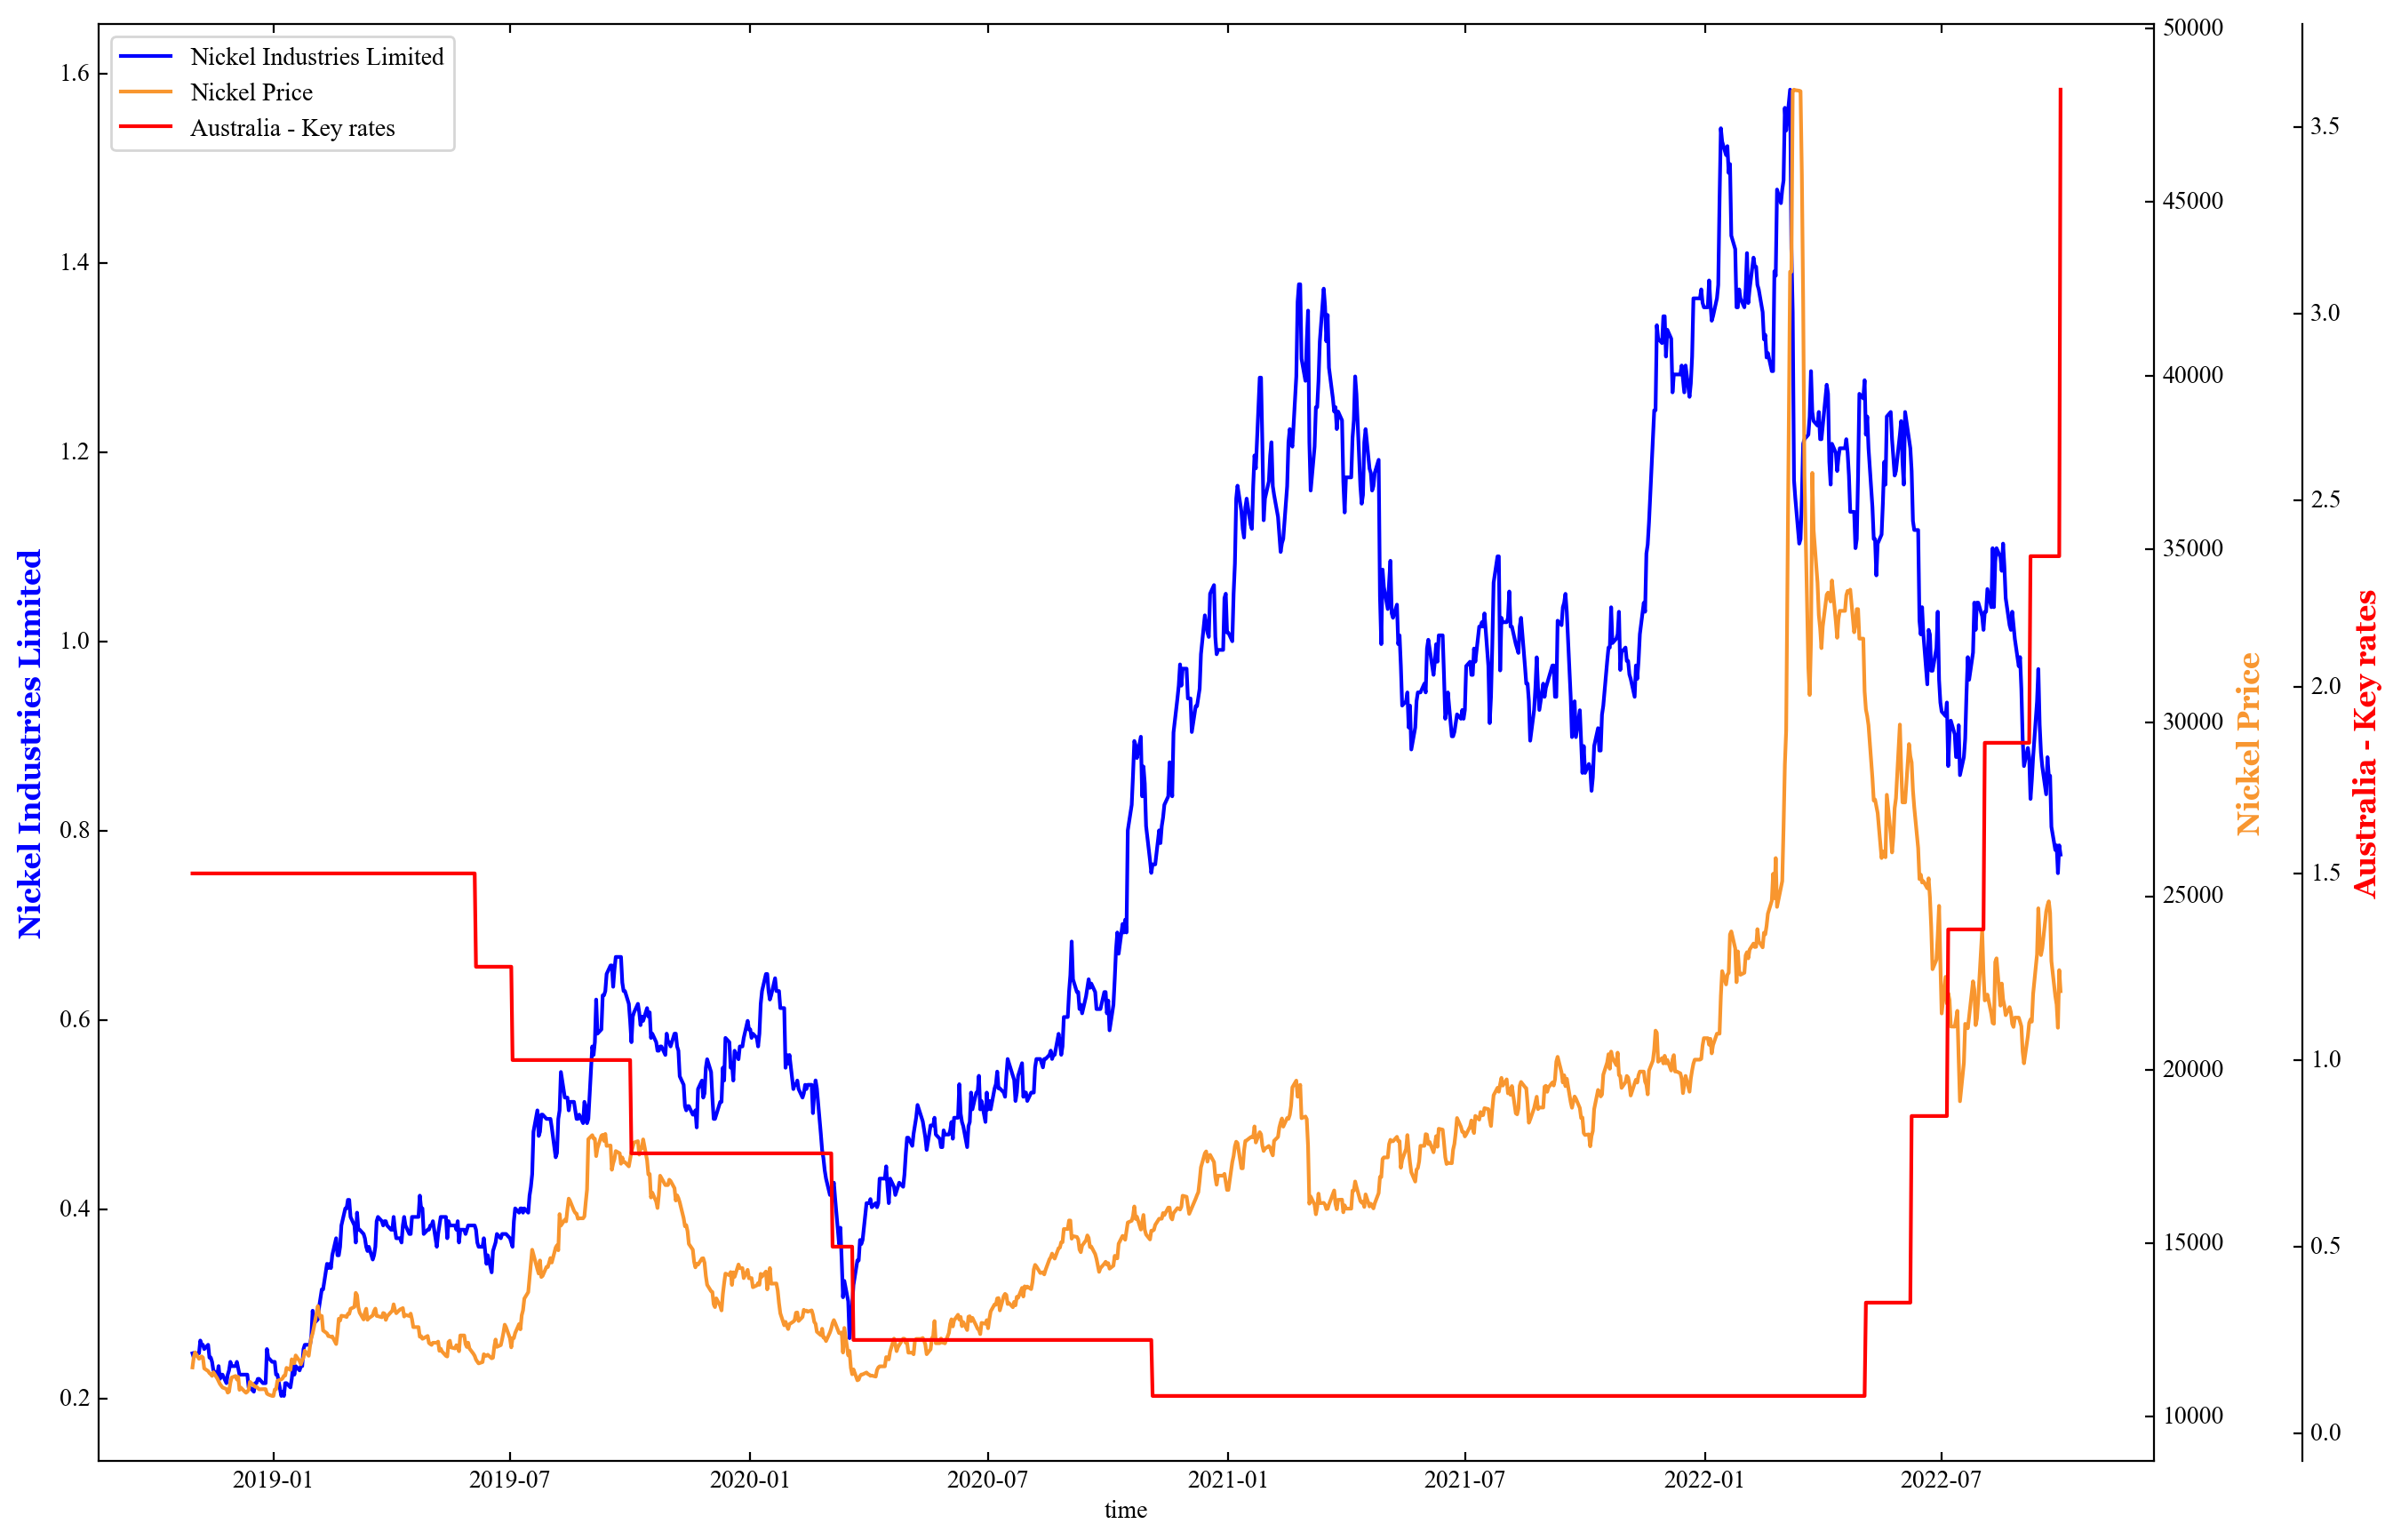

In [32]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.family':"Times New Roman"})

plot_nick_rate_nic(nickel_df, rates, nic_df)

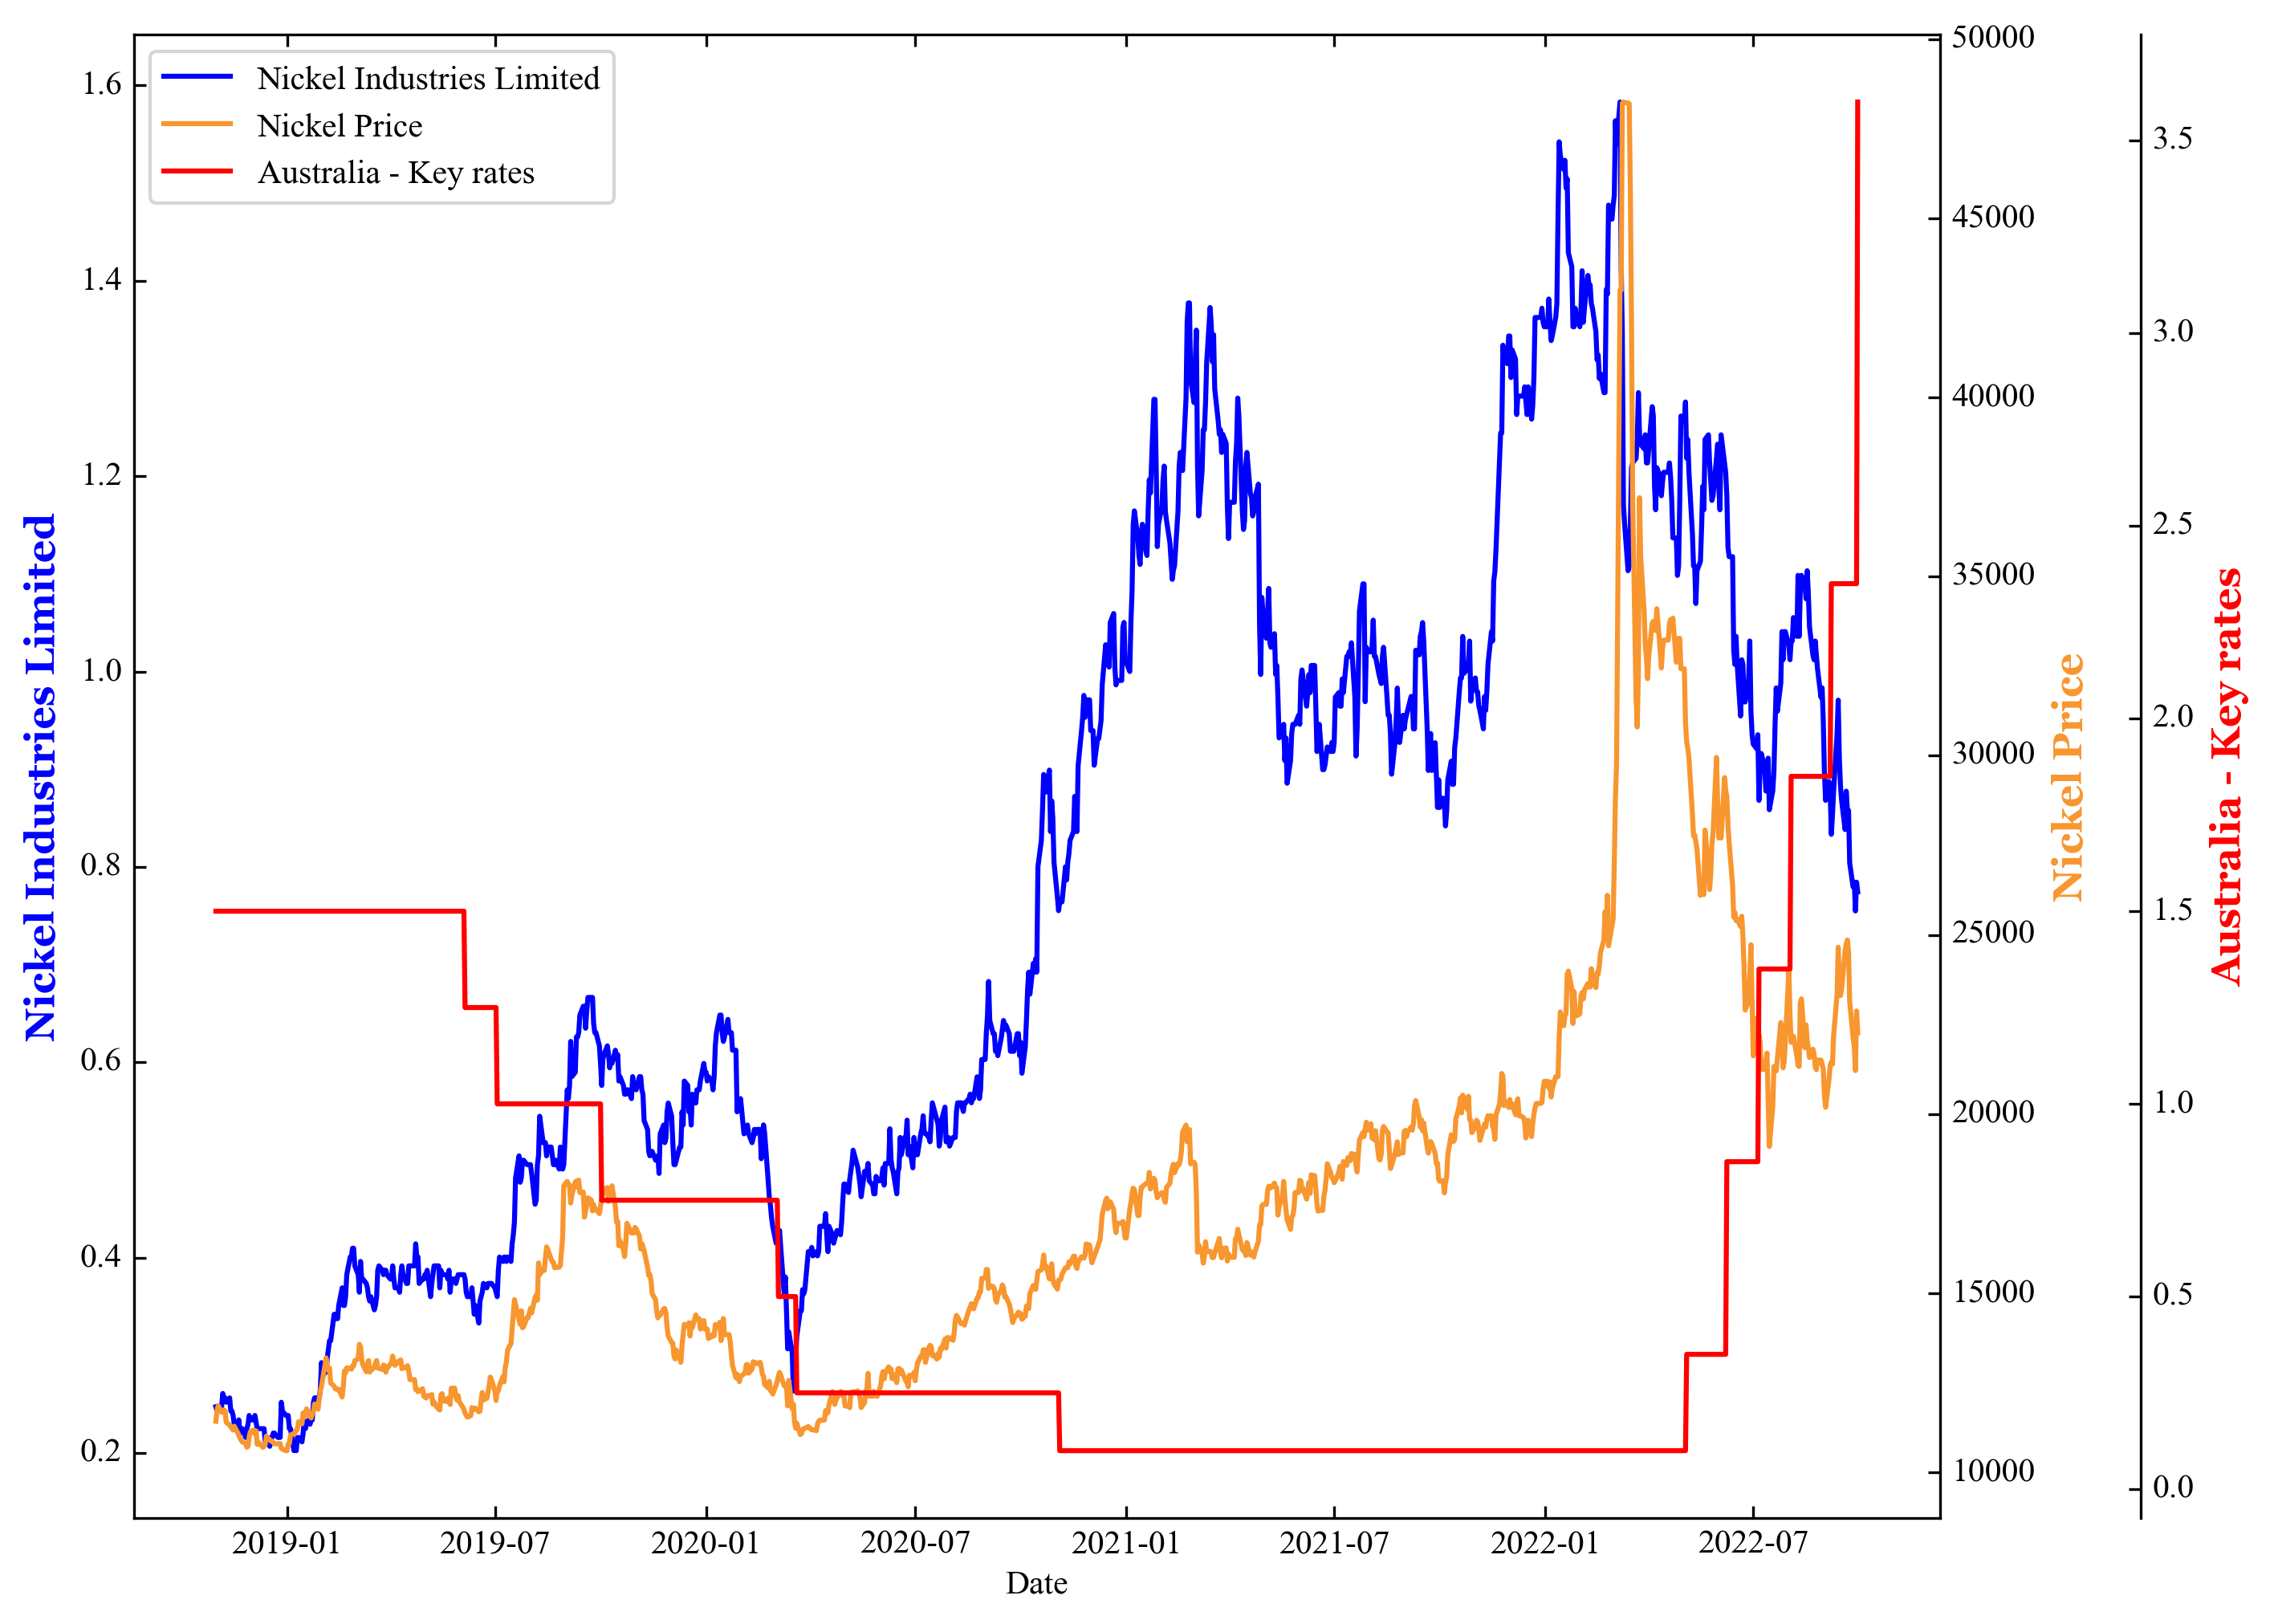

In [33]:
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.family':"Times New Roman"})

host = host_subplot(111, axes_class=axisartist.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))
    
par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)
    
p1, = host.plot(nic_df.index, nic_df['Close'], label="Nickel Industries Limited", color="blue")
p2, = par1.plot(nic_df.index, nickel_df['Close'], label="Nickel Price", color="#f8962f")
p3, = par2.plot(nic_df.index, rates['rate'], label="Australia - Key rates", color="red")
    
host.set_xlabel("Date", fontsize=12)
host.set_ylabel("Nickel Industries Limited")
par1.set_ylabel("Nickel Price")
par2.set_ylabel("Australia - Key rates")
    
host.legend()
    
host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())
    
host.axis["left"].label.set(fontsize=12, fontweight='bold', fontfamily="Georgia")
par1.axis["right"].label.set(fontsize=12, fontweight='bold', fontfamily="Georgia")
par2.axis["right"].label.set(fontsize=12, fontweight='bold', fontfamily="Georgia")
    
fig = plt.gcf()
fig.set_size_inches(12, 8)
fig.set_dpi(300)

# plt.savefig('images/Example.png', dpi=300)

plt.show()

In [34]:
data = union_data_in_one_df(nickel_df, rates, nic_df, currency_df, production, mining, ind_exp)

In [35]:
data.describe().to_csv('data_description.csv')

In [36]:
(endog, exog) = get_endog_and_exog(data)

Text(0.5, 0.98, '')

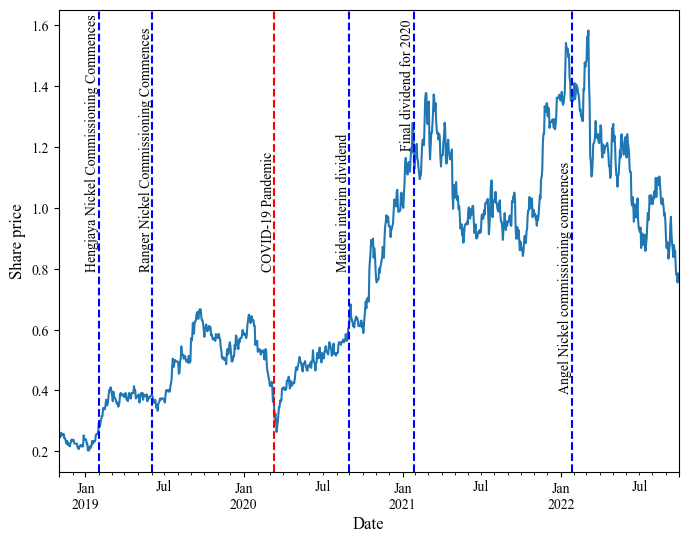

In [37]:
plt.rcParams["font.family"] = "Times New Roman"

ax = data[endog].plot(figsize=(8, 6))

ax.axvline('2020-03-11', color='red', linestyle='--',)
plt.text('2020-02-11', 0.8, s='COVID-19 Pandemic', rotation=90)


ax.axvline('2019-02-01', color='blue', linestyle='--',)
plt.text('2019-01-01', 0.8, s='Hengjaya Nickel Commissioning Commences', rotation=90)

ax.axvline('2019-06-03', color='blue', linestyle='--',)
plt.text('2019-05-03', 0.8, s='Ranger Nickel Commissioning Commences', rotation=90)

ax.axvline('2020-08-31', color='blue', linestyle='--',)
plt.text('2020-07-31', 0.8, s='Maiden interim dividend', rotation=90)

ax.axvline('2021-01-28', color='blue', linestyle='--',)
plt.text('2020-12-28', 1.2, s='Final dividend for 2020', rotation=90)

ax.axvline('2022-01-27', color='blue', linestyle='--',)
plt.text('2021-12-27', 0.4, s='Angel Nickel commissioning commences', rotation=90)

ax.set_xlabel("")

ax.set_ylabel("Share price", fontname="Times New Roman", fontsize=12)

ax.set_label("")


ax.get_figure().gca().set_xlabel("Date", fontname="Times New Roman", fontsize=12)
ax.get_figure().suptitle('')

# ax.set_title("Share price of Nickel Industries Limited", fontname="Times New Roman", fontsize=18)

# plt.savefig('images/Share price of Nickel Industries Limited.png', dpi=300)

array([<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>],
      dtype=object)

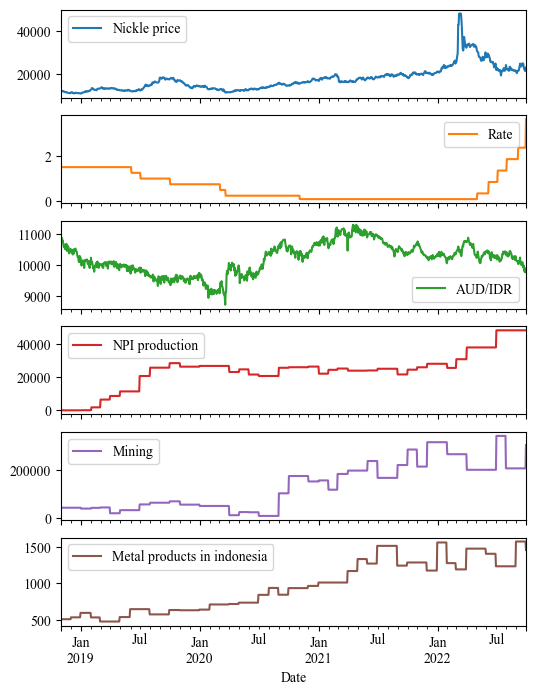

In [38]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.family':"Times New Roman"})

data[exog].plot(subplots=True, figsize=(6, 8), linewidth=1.5, sharey=False)

# plt.savefig('images/Data.png', dpi=300)

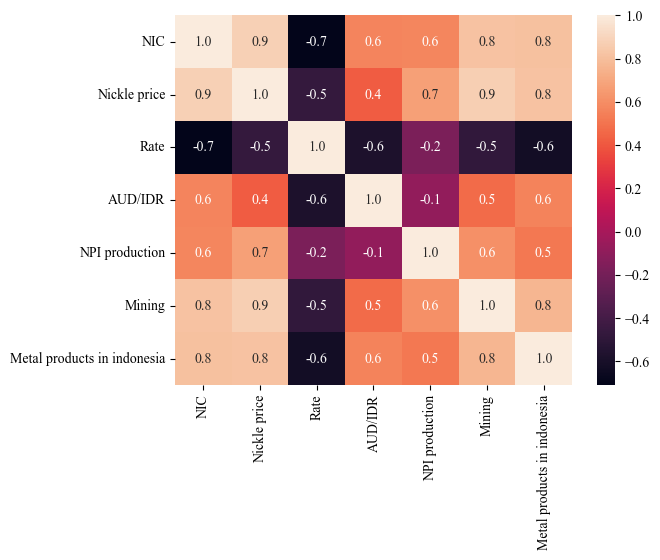

In [39]:
import seaborn as sns

sns.heatmap(data.corr(method="spearman"), annot=True, fmt=".1f")

plt.savefig('images/Heatmap.png', dpi=300)

In [40]:
currency_df['Close']

Date
2018-10-31 00:00:00+11:00    10830.000000
2018-11-01 00:00:00+11:00    10760.200195
2018-11-02 00:00:00+11:00    10885.799805
2018-11-05 00:00:00+11:00    10755.000000
2018-11-06 00:00:00+11:00    10806.299805
                                 ...     
2022-12-26 00:00:00+11:00    10447.911133
2022-12-27 00:00:00+11:00    10525.360352
2022-12-28 00:00:00+11:00    10511.037109
2022-12-29 00:00:00+11:00    10652.522461
2022-12-30 00:00:00+11:00    10568.023438
Name: Close, Length: 1088, dtype: float64

In [41]:
data

,NIC,Nickle price,Rate,AUD/IDR,NPI production,Mining,Metal products in indonesia
Date,,,,,,,
2018-10-31 00:00:00+11:00,0.247705,11425.5,1.50,10830.000000,0.000000,40579.0,506.75
2018-11-01 00:00:00+11:00,0.243202,11718.5,1.50,10760.200195,0.000000,43322.0,506.75
2018-11-02 00:00:00+11:00,0.247705,11860.5,1.50,10885.799805,0.000000,43322.0,506.75
2018-11-05 00:00:00+11:00,0.247705,11675.5,1.50,10755.000000,0.000000,43322.0,506.75
2018-11-06 00:00:00+11:00,0.261217,11699.5,1.50,10806.299805,0.000000,43322.0,506.75
...,...,...,...,...,...,...,...
2022-09-26 00:00:00+10:00,0.779563,22125.0,2.35,9813.086914,48393.333333,205722.0,1568.34
2022-09-27 00:00:00+10:00,0.784466,21881.5,2.35,9837.520508,48393.333333,205722.0,1568.34
2022-09-28 00:00:00+10:00,0.755049,21212.5,2.35,9766.641602,48393.333333,205722.0,1568.34


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                    NIC   No. Observations:                  993
Model:                 ARIMA(4, 1, 1)   Log Likelihood                2160.447
Date:                Sun, 26 Mar 2023   AIC                          -4296.895
Time:                        04:04:18   BIC                          -4238.098
Sample:                    10-31-2018   HQIC                         -4274.539
                         - 08-19-2022                                         
Covariance Type:                  opg                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Nickle price                 3.546e-06   1.08e-06      3.278      0.001    1.43e-06    5.67e-06
Rate                           -0.0349      0.021     -1.642      0.101      -0.

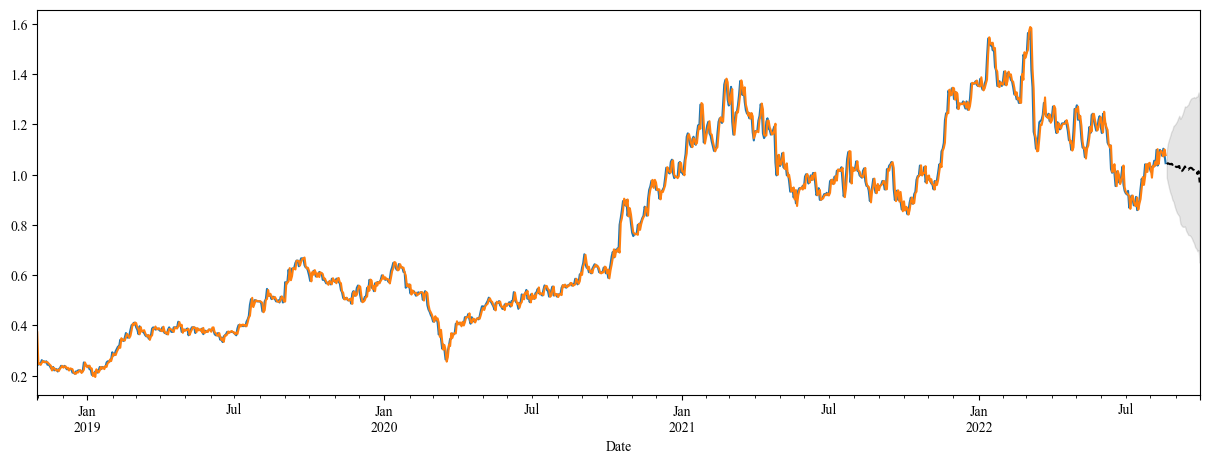

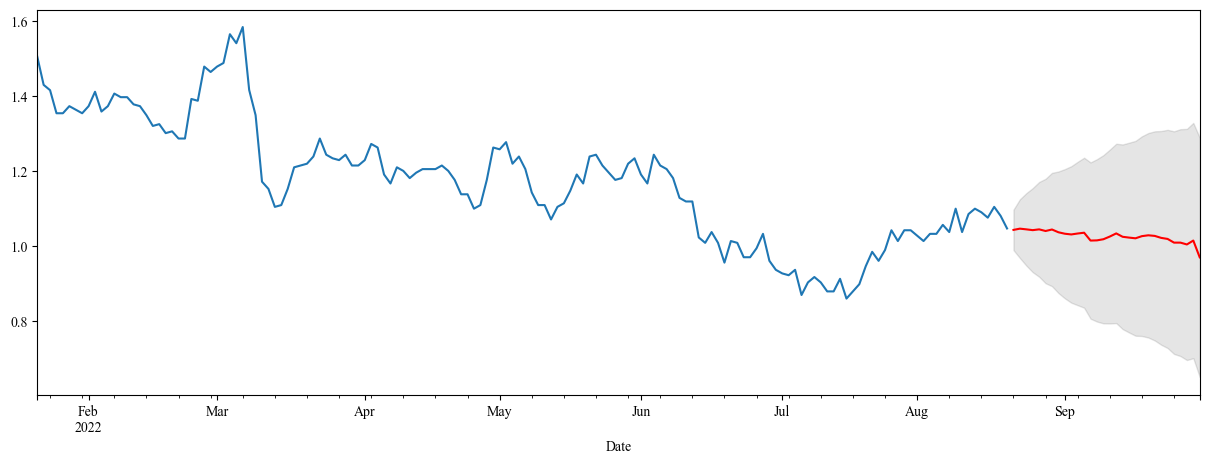

In [42]:
first_model(data)